In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
from d2l import torch as d2l
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
np.set_printoptions(suppress=True)
import torch.nn as nn
import matplotlib.pyplot as plt
import time
device=d2l.try_gpu()

In [155]:
def ode(y, t, beta, gamma, mu):
    S, I, R, D, N = y
    beta=t
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]
def guiyihua(data):
    col_min, _ = torch.min(data, dim=0)
    col_max, _ = torch.max(data, dim=0)
    return col_min, col_max, F.normalize(data, dim=0)
def quweifen(data,t):
    SIR = data[:, :5]
    dSIR_dt = data[:, :5].clone()
    dSIR_dt[1:, :] = SIR[1:, :] - SIR[:-1, :]
    dSIR_dt[0, :] = 0
    dSIR_dt /= t[1] - t[0]
    return dSIR_dt
def woplot(data,t):
    plt.plot(t, data[:,0], label='S')
    plt.plot(t, data[:,1], label='I')
    plt.plot(t, data[:,2], label='R')
    plt.plot(t, data[:,3], label='D')
    plt.plot(t, data[:,4], label='N')
    plt.legend()
    plt.show()

In [157]:
y0 = [999, 1, 0, 0, 1000]
T=150
t = torch.arange(1, T + 1, dtype=torch.float32)
beta = 0.4
gamma = 0.1
mu = 0.005

simulation = torch.tensor(odeint(ode, y0, t, args=(beta, gamma, mu)))
# weifen=torch.cat((quweifen(simulation,t), t.unsqueeze(-1)), dim=1)
simulation=torch.cat((simulation, t.unsqueeze(-1)), dim=1)
col_min,col_max,simulation_normalized =guiyihua(simulation)
weifen=quweifen(simulation,t)+torch.normal(0, 0.1, (T,5))

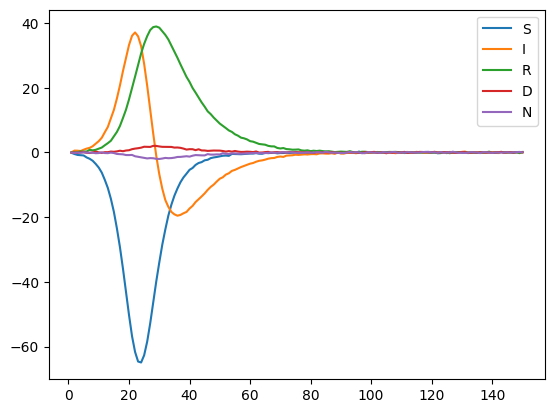

In [159]:
woplot(weifen,t)

In [7]:
total=torch.cat((weifen,simulation),dim=1)
cmin,cmax,total_normalized =guiyihua(total)

In [243]:
def simple_with_time(data_with_time, batch_size, train_ratio,isshuffle=False):
    total_size = len(data_with_time)
    train_size = int(total_size * train_ratio)

    train_dataset = TensorDataset(data_with_time[:train_size, 5:].type(torch.float32),data_with_time[:train_size, :5].type(torch.float32))
    test_dataset = TensorDataset( data_with_time[train_size:, 5:].type(torch.float32),data_with_time[train_size:, :5].type(torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=isshuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [9]:
train_data,test_data=simple_with_time(total,5,0.9)
for x,y in train_data:
    print(x)
    break

tensor([113.,   5.,  34., 116.,  35.])


In [302]:
class para(nn.Module):
    def __init__(self,in_size):
        super(para,self).__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_size,10),
            nn.ReLU(),
            nn.Linear(10,5),
            nn.ReLU(),
            nn.Linear(5,1)
        )
    def forward(self,x):
        return self.layer(x)

In [268]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.S=para(in_size=1)
        self.I=para(in_size=1)
        self.R=para(in_size=1)
        self.D=para(in_size=1)
        self.N=para(in_size=1)

    def forward(self, x):
        dsdt=-0.4*self.S(x)*self.I(x)/self.N(x)
        didt=0.4*self.S(x)*self.I(x)/self.N(x)-0.105*self.I(x)
        drdt=0.1*self.I(x)
        dddt=0.005*self.I(x)
        dndt=-0.005*self.I(x)
        output = torch.stack([dsdt, didt, drdt, dddt, dndt], dim=0)
        return output

net = Net()
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
net.apply(init_weights)

Net(
  (S): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=10, bias=True)
      (7): ReLU()
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (I): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=10, bias=True)
      (7): ReLU()
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (R): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_f

In [269]:
criterion = nn.MSELoss()
optimizerS = torch.optim.Adam(net.S.parameters(), lr=0.005)
optimizerI= torch.optim.Adam(net.I.parameters(), lr=0.005)
optimizerR = torch.optim.Adam(net.R.parameters(), lr=0.005)
optimizerD = torch.optim.Adam(net.D.parameters(), lr=0.005)
optimizerN = torch.optim.Adam(net.N.parameters(), lr=0.005)
op=torch.optim.Adam(net.parameters(), lr=0.005)


net.to(device)
for epoch in range(100):
    for X_train, y_train in train_data:
        X_train = X_train.reshape(-1, 1)
        X_train = X_train.to(device)
        y_train=y_train.to(device)
        y_pred = net.S(X_train)
        optimizerS.zero_grad()
        loss_S = criterion(y_pred.squeeze().T, y_train[:,0])
        loss_S.backward()
        optimizerS.step()

        y_pred = net.I(X_train)
        optimizerI.zero_grad()
        loss_I= criterion(y_pred.squeeze().T, y_train[:,1])
        loss_I.backward()
        optimizerI.step()

        y_pred = net.R(X_train)
        optimizerR.zero_grad()
        loss_R = criterion(y_pred.squeeze().T, y_train[:,2])
        loss_R.backward()
        optimizerR.step()

        y_pred = net.D(X_train)
        optimizerS.zero_grad()
        loss_D = criterion(y_pred.squeeze().T, y_train[:,3])
        loss_D.backward()
        optimizerD.step()

        y_pred = net.N(X_train)
        optimizerS.zero_grad()
        loss_N = criterion(y_pred.squeeze().T, y_train[:,4])
        loss_N.backward()
        optimizerN.step()

        op.zero_grad()
        y_pred = net(X_train)
        loss=criterion(y_pred.squeeze().T, y_train)
        loss.backward()
        op.step()

    with torch.no_grad():
        test_loss = 0
        for X_test, y_test in test_data:
            X_test = X_test.reshape(-1, 1).to(device)
            y_test=y_test.to(device)
            y_pred = net(X_test)
            test_loss += criterion(y_pred.squeeze().T, y_test).item()

    if epoch%10==0:
        print('Epoch:', epoch, 'Train loss:', loss.item(), 'Test loss:', test_loss/len(test_data))
net.to('cpu')

C:\Users\Jiang\AppData\Local\Temp\ipykernel_22648\1036263531.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  loss_S = criterion(y_pred.squeeze().T, y_train[:,0])
C:\Users\Jiang\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (60) must match the size of tensor b (10) at non-singleton dimension 0

In [243]:
test=total[:,-1].float().reshape(-1,1)
print(test.shape)
out=net(test).detach().numpy()
out.shape

torch.Size([200, 1])


(5, 200, 1)

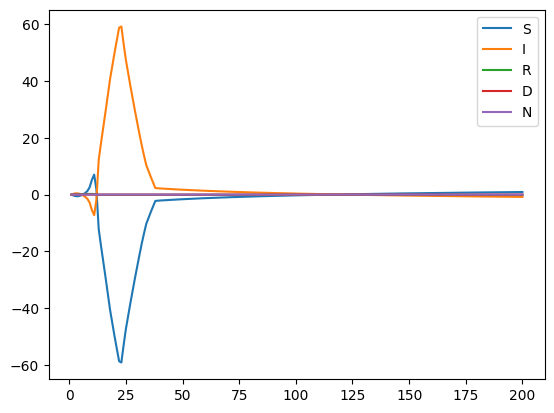

In [244]:
woplot(out.squeeze().T,t)

In [106]:
# 输入五个和时间预测beta
class betaNet(nn.Module):
    def __init__(self):
        super(betaNet, self).__init__()
        self.beta=para(in_size=1)

    def forward(self, x):
        t=x[:,-1].reshape(-1,1)
        S=x[:,0].reshape(-1,1)
        I=x[:,1].reshape(-1,1)
        R=x[:,2].reshape(-1,1)
        D=x[:,3].reshape(-1,1)
        N=x[:,4].reshape(-1,1)
        dsdt=-self.beta(t)*S*I/N
        didt=self.beta(t)*S*I/N-0.105*I
        # print(didt.shape)
        drdt=0.1*I
        dddt=0.005*I
        dndt=-0.005*I
        output = torch.stack([dsdt, didt, drdt, dddt, dndt], dim=0)
        return output

betanet = betaNet()
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
betanet.apply(init_weights)

betaNet(
  (beta): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

In [114]:
train_data,test_data=simple_with_time(total,10,0.9)
for x,y in train_data:
    print(x[:,-1])
    break

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


In [115]:
criterion = nn.MSELoss()
op=torch.optim.Adam(betanet.parameters(), lr=0.005)

betanet.to(device)
for epoch in range(200):
    for X_train, y_train in train_data:
        X_train = X_train.to(device)
        y_train=y_train.to(device)
        y_pred = betanet(X_train)
        op.zero_grad()
        loss_beta = criterion(y_pred.squeeze().T, y_train)
        loss_beta.backward()
        op.step()

    with torch.no_grad():
        test_loss = 0
        for X_test, y_test in test_data:
            X_test = X_test.to(device)
            y_test=y_test.to(device)
            y_pred = betanet(X_test)
            test_loss += criterion(y_pred.squeeze().T, y_test).item()

    if epoch%10==0:
        print('Epoch:', epoch, 'Train loss:', loss_beta.item(), 'Test loss:', test_loss/len(test_data))
betanet.to('cpu')

Epoch: 0 Train loss: 0.008756891824305058 Test loss: 0.011106532998383045
Epoch: 10 Train loss: 0.008759389631450176 Test loss: 0.011106196790933609
Epoch: 20 Train loss: 0.00875960011035204 Test loss: 0.011106169316917658
Epoch: 30 Train loss: 0.008759601972997189 Test loss: 0.011106168385595083
Epoch: 40 Train loss: 0.008759601972997189 Test loss: 0.011106168385595083
Epoch: 50 Train loss: 0.008759602904319763 Test loss: 0.011106168385595083
Epoch: 60 Train loss: 0.008759602904319763 Test loss: 0.011106168385595083
Epoch: 70 Train loss: 0.008759603835642338 Test loss: 0.011106168385595083
Epoch: 80 Train loss: 0.008759604766964912 Test loss: 0.011106167919933796
Epoch: 90 Train loss: 0.008759605698287487 Test loss: 0.011106167919933796
Epoch: 100 Train loss: 0.008759605698287487 Test loss: 0.011106167919933796
Epoch: 110 Train loss: 0.008759606629610062 Test loss: 0.011106167919933796
Epoch: 120 Train loss: 0.008759606629610062 Test loss: 0.011106166988611221
Epoch: 130 Train loss: 0

betaNet(
  (beta): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

In [116]:
beta=betanet.beta(total[:,-1].reshape(-1,1).type(torch.float32))
beta.mean()

tensor(0.4014, grad_fn=<MeanBackward0>)

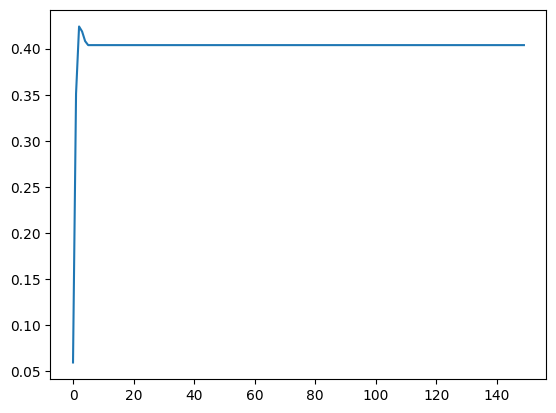

In [117]:
plt.plot(beta.detach().numpy())

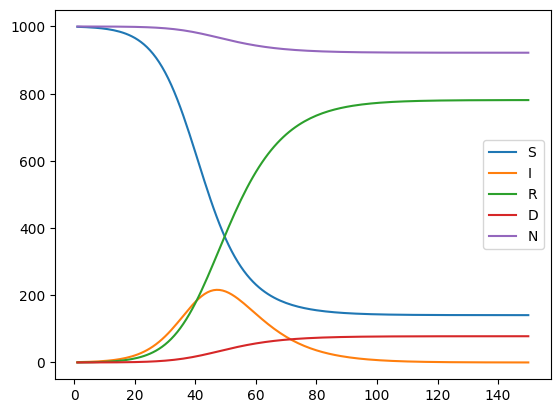

In [303]:
def ds_dt(t, S, I, N, beta):
    return -beta * S * I / N

def di_dt(t, S, I, N, beta, gamma, mu):
    return beta * S * I / N - (gamma + mu) * I

def dr_dt(t, I, gamma):
    return gamma * I

def dd_dt(t, I, mu):
    return mu * I

def dn_dt(t, I, mu):
    return -mu * I

S0 = 999
I0 = 1
R0 = 0
D0 = 0
N0 = S0 + I0 + R0 + D0
gamma = 0.1
mu = 0.01
beta = lambda t: 0.3 * torch.exp(t / 150 * torch.log(torch.tensor(0.5)))

t0, tmax = 1, 150
dt = 1.0
t = torch.arange(t0, tmax + dt, dt)

S = torch.zeros_like(t)
I = torch.zeros_like(t)
R = torch.zeros_like(t)
D = torch.zeros_like(t)
N = torch.zeros_like(t)

S[0] = S0
I[0] = I0
R[0] = R0
D[0] = D0
N[0] = N0

# Solve the system of differential equations using the Euler method
for i in range(1, len(t)):
    S[i] = S[i-1] + ds_dt(t[i-1], S[i-1], I[i-1], N[i-1], beta(t[i-1])) * dt
    I[i] = I[i-1] + di_dt(t[i-1], S[i-1], I[i-1], N[i-1], beta(t[i-1]), gamma, mu) * dt
    R[i] = R[i-1] + dr_dt(t[i-1], I[i-1], gamma) * dt
    D[i] = D[i-1] + dd_dt(t[i-1], I[i-1], mu) * dt
    N[i] = N[i-1] + dn_dt(t[i-1], I[i-1], mu) * dt

S,I,R,D,N=S.reshape(-1,1),I.reshape(-1,1),R.reshape(-1,1),D.reshape(-1,1),N.reshape(-1,1)
simulation=torch.cat((S,I,R,D,N),dim=1)
simulation=torch.cat((simulation, t.unsqueeze(-1)), dim=1)
col_min,col_max,simulation_normalized =guiyihua(simulation)
weifen=quweifen(simulation,t)+torch.normal(0, 0.1, (T,5))
woplot(simulation,t)

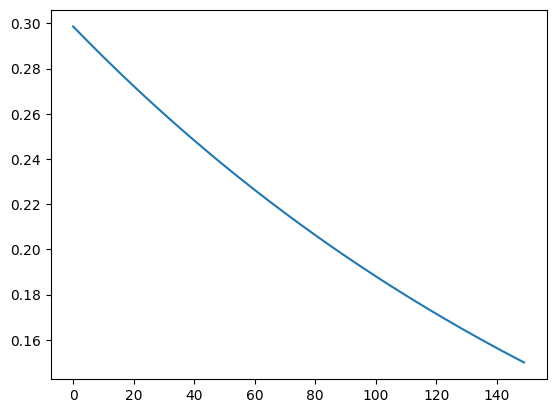

In [304]:
plt.plot(beta(t))

In [305]:
total=torch.cat((weifen,simulation),dim=1)
total[:,-1]=(total[:,-1]-min(total[:,-1]))/150.
features=total[:,-1]
# mi,ma,total_normalized =guiyihua(simulation)
train_data,test_data=simple_with_time(total,10,0.7,True)

In [306]:
for x,y in train_data:
    print(x)
    break

tensor([[4.8477e+02, 2.1273e+02, 2.7500e+02, 2.7500e+01, 9.7250e+02, 2.9333e-01],
        [3.4887e+02, 2.0725e+02, 4.0353e+02, 4.0353e+01, 9.5965e+02, 3.3333e-01],
        [3.8878e+02, 2.1413e+02, 3.6099e+02, 3.6099e+01, 9.6390e+02, 3.2000e-01],
        [2.7259e+02, 1.7579e+02, 5.0147e+02, 5.0147e+01, 9.4985e+02, 3.6667e-01],
        [9.9793e+02, 1.6718e+00, 3.5987e-01, 3.5987e-02, 9.9996e+02, 2.0000e-02],
        [1.4462e+02, 1.0758e+01, 7.6784e+02, 7.6784e+01, 9.2322e+02, 6.2667e-01],
        [1.4733e+02, 1.7617e+01, 7.5914e+02, 7.5914e+01, 9.2409e+02, 5.8667e-01],
        [6.2469e+02, 1.8054e+02, 1.7707e+02, 1.7707e+01, 9.8229e+02, 2.6000e-01],
        [4.5893e+02, 2.1517e+02, 2.9628e+02, 2.9628e+01, 9.7037e+02, 3.0000e-01],
        [3.3101e+02, 2.0231e+02, 4.2425e+02, 4.2425e+01, 9.5757e+02, 3.4000e-01]])


In [317]:
betanet = betaNet()
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
betanet.apply(init_weights)
criterion = nn.MSELoss()
op=torch.optim.Adam(betanet.parameters(), lr=0.005)

betanet.to(device)
for epoch in range(100):
    for X_train, y_train in train_data:
        X_train = X_train.to(device)
        y_train=y_train.to(device)
        y_pred = betanet(X_train)
        op.zero_grad()
        loss_beta = criterion(y_pred.squeeze().T, y_train)
        loss_beta.backward()
        op.step()

    with torch.no_grad():
        test_loss = 0
        for X_test, y_test in test_data:
            X_test = X_test.to(device)
            y_test=y_test.to(device)
            y_pred = betanet(X_test)
            test_loss += criterion(y_pred.squeeze().T, y_test).item()

    if epoch%10==0:
        print('Epoch:', epoch, 'Train loss:', loss_beta.item(), 'Test loss:', test_loss/len(test_data))
betanet.to('cpu')

Epoch: 0 Train loss: 61.40610122680664 Test loss: 0.011009165830910207
Epoch: 10 Train loss: 0.363596111536026 Test loss: 0.010207677818834781
Epoch: 20 Train loss: 0.20656217634677887 Test loss: 0.010200759209692479
Epoch: 30 Train loss: 0.2160920649766922 Test loss: 0.010201045870780944
Epoch: 40 Train loss: 0.3608212172985077 Test loss: 0.010195283591747284
Epoch: 50 Train loss: 0.41772276163101196 Test loss: 0.010191307589411735
Epoch: 60 Train loss: 0.24697059392929077 Test loss: 0.010189519822597503
Epoch: 70 Train loss: 0.7032825946807861 Test loss: 0.010184482671320438
Epoch: 80 Train loss: 0.3035430908203125 Test loss: 0.01018325388431549
Epoch: 90 Train loss: 0.5853343605995178 Test loss: 0.01017964668571949


betaNet(
  (beta): para(
    (layer): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=1, bias=True)
    )
  )
)

In [318]:
beta = betanet.beta(features.reshape(-1, 1).type(torch.float32))
beta.mean()

tensor(0.2456, grad_fn=<MeanBackward0>)

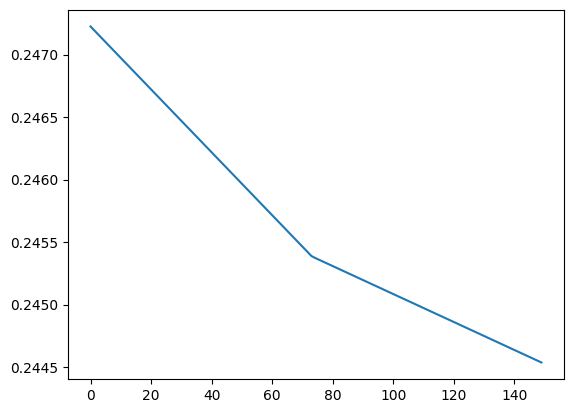

In [319]:
plt.plot(beta.detach().numpy())

In [320]:
output=betanet(total[:,:5]).squeeze().T.detach().numpy()

In [321]:
output.shape

(150, 5)

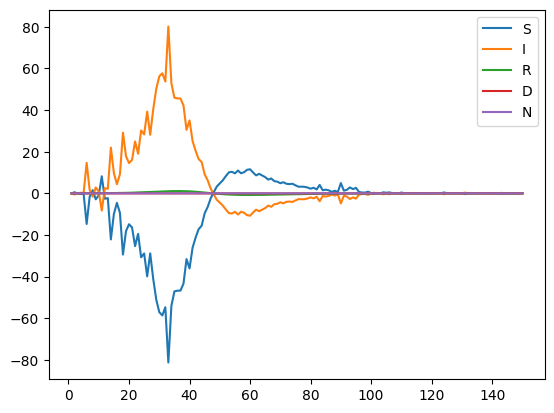

In [322]:
woplot(output,t)

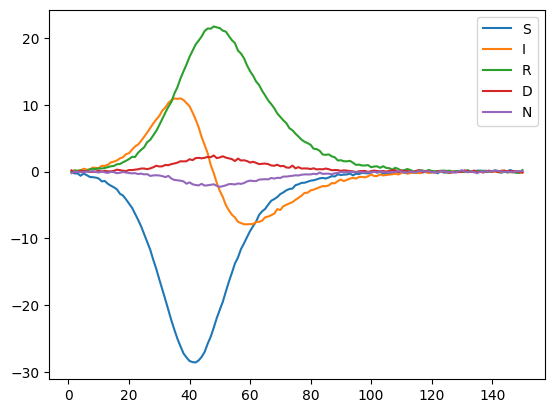

In [323]:
woplot(weifen,t)